In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
data_dir = "../dataset"
batch_size = 32
image_size = (224,224)

train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split = 0.2,
    subset = "training",
    seed = 23
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split = 0.2,
    subset = "validation",
    seed = 23
)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
FILL_MODE = "nearest"

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    layers.RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE),
    layers.RandomZoom(0.1, fill_mode=FILL_MODE)
])

In [5]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top = False,
    weights = "imagenet"
    )

base_model.trainabel = False

In [6]:
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)

x = preprocess_input(x)
x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(5,activation="softmax")(x)

model = tf.keras.Model(inputs=inputs,outputs=outputs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)


In [7]:
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 2,388,485 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
#CallBacks

#Callback for reducing learning rate
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',          
    factor=0.5,                  
    patience=3,                  
    verbose=1                    
)

#Callback for early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',              
    patience=5,                      
    restore_best_weights=True,
    verbose = 1,
)

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks = [early_stop,lr_scheduler]
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 133s 998ms/step - accuracy: 0.8488 - loss: 0.4376 - val_accuracy: 0.8820 - val_loss: 0.3869 - learning_rate: 4.0000e-04
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 962ms/step - accuracy: 0.9834 - loss: 0.0647 - val_accuracy: 0.9590 - val_loss: 0.1433 - learning_rate: 4.0000e-04
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 945ms/step - accuracy: 0.9885 - loss: 0.0363 - val_accuracy: 0.4790 - val_loss: 5.8082 - learning_rate: 4.0000e-04
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 970ms/step - accuracy: 0.9894 - loss: 0.0387 - val_accuracy: 0.9140 - val_loss: 0.7755 - learning_rate: 4.0000e-04
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9906 - loss: 0.0302
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 912ms/step - accuracy: 0.9906 - loss: 0.0302 - val_accuracy: 0.9590 - val_loss: 0.3322 - learning_rate: 4.0000e-04
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 9

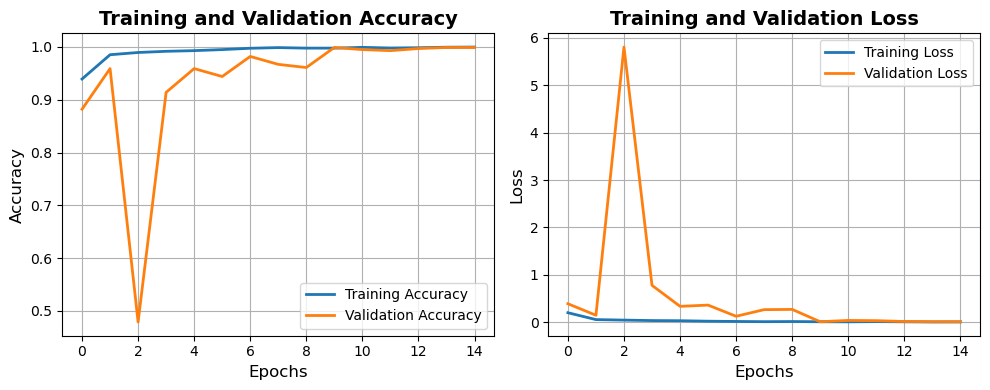

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Accuracy",fontsize=12)
plt.legend()
plt.title("Training and Validation Accuracy",fontsize=14,fontweight='bold')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss",linewidth=2)
plt.plot(val_loss, label="Validation Loss",linewidth=2)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.legend()
plt.title("Training and Validation Loss",fontsize=14,fontweight='bold')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs,axis=1)

y_true = np.concatenate([y for x, y in val_data], axis=0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 931ms/step


2025-07-30 16:40:40.579395: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
class_names = os.listdir(data_dir)
report_text = classification_report(y_true, y_pred, target_names=class_names)
print("```\n" + report_text + "\n```")

```
                precision    recall  f1-score   support

      basophil       1.00      1.00      1.00       182
      monocyte       1.00      1.00      1.00       200
  erythroblast       1.00      1.00      1.00       186
seg_neutrophil       1.00      1.00      1.00       210
    myeloblast       1.00      1.00      1.00       222

      accuracy                           1.00      1000
     macro avg       1.00      1.00      1.00      1000
  weighted avg       1.00      1.00      1.00      1000

```


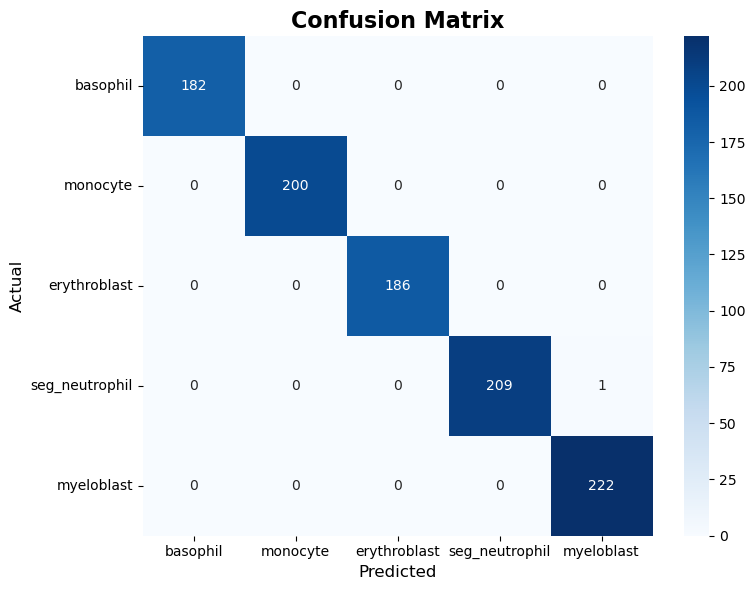

In [13]:
cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.title("Confusion Matrix",fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

In [15]:
#Saving model
model.save("../models/cell_classifier_transfer_learning.keras")